# Anime Character GAN
### Programmed by: [Aiden Zelakewicz](github.com/Shockblack)

There are many common examples for beginner and intermediate GAN training sets.
One set you occasionally see is the artificial anime face set.
This set of characters are all very similar and of an old anime style.
I asked myself: "Why not try doing this example with modern anime characters?"

So here we are.
This notebook contains a structured framework to explore the data itself.

In [14]:
# Start by importing necessary packages
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import os

%matplotlib inline

#### Now that our packages are imported, lets start by loading in the dataset and view some features about it.

In [15]:
# Creating a custom PyTorch dataset
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        # Very compact way to check amount of files in directory
        return len([entry for entry in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, entry))])

    def __getitem__(self, idx):
        # Getting the image
        img_name = os.path.join(self.root_dir, os.listdir(self.root_dir)[idx])
        img = io.imread(img_name)
        # Performing the transformation
        if self.transform:
            img = self.transform(img)

            # Performing the cropping
            img = transforms.functional.crop(img, 5, 0, 100, 100)
            img = transforms.functional.resize(img, (64,64))
        
        return img

In [16]:
# Define the data directory
data_dir = 'data/'

# Use PyTorch's ImageFolder to load the image data
image_dataset = AnimeDataset(data_dir, transform=transforms.Compose([transforms.ToTensor()]))

# Now let's split the data into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = random_split(image_dataset, [train_size, val_size])

# Now let's create a DataLoader to load the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#### Let's load a couple images to make sure everything is working as it should be

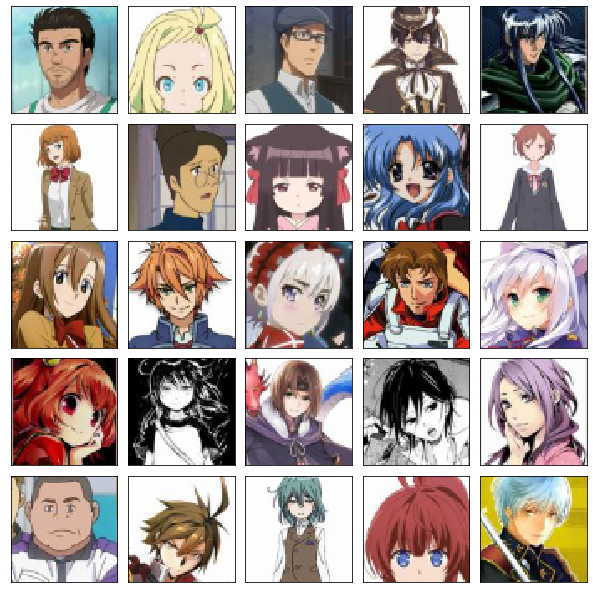

In [23]:
# Looking at a batch of images
dataiter = iter(train_loader)
images = dataiter.next()

fig = plt.figure(figsize=(10, 10))
ax = [fig.add_subplot(5,5,i+1) for i in range(25)]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)

for axes in ax:
    axes.set_xticklabels([])
    axes.set_yticklabels([])
    axes.set_yticks([])
    axes.set_xticks([])
    axes.set_aspect('equal')

for k in range(25):

    plt.sca(ax[k])
    plt.imshow(np.transpose(images[k], (1,2,0)), aspect='auto', interpolation='none')


# plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.show()

#### Ridding of bad images
Here I am going to import the json file which contains the image names as well as the "box" which contains the face of the image.
This will allow me to only include images which have a detectable face.
I also limit it so that the probability on whether it is a face or not is greater than 90%.

In [12]:
# Getting the JSON file imported and only keeping those which have a face.
import json

file = open('detected_faces.json')
data = json.load(file)

gooddata = dict()
baddata = dict()

for key in data.keys():
    newkey = key.split('anime-gan/data/')[-1]
    if len(data[key]) > 0 and data[key][0]['score'] > 0.9:
        gooddata[newkey] = data[key]
    else:
        baddata[newkey] = data[key]

file.close()

print(len(data), "images originally downloaded.")
print(len(gooddata),'images have detectable faces.')

# Deleting the object in case it's taking up too much memory, I'm just worried.
del data

67006 images originally downloaded.
26928 images have detectable faces.


### Removing bad images
Here I am just going to delete all the bad images so that they don't interfere with training.

In [13]:
badkeys = list(baddata.keys())

for key in badkeys:
    os.rename('data/'+key, 'bad_images/'+key)
    # os.remove('data/' + key)